In [1]:
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay,mean_squared_error, r2_score, accuracy_score, roc_curve, auc, RocCurveDisplay, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
import warnings

pd.set_option("future.no_silent_downcasting", True)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
from season_to_date_stats_pergame import gm_logs
from szn_to_date_goalie_stats import gm_logs_goalie
from szn_to_date_team_stats import team_level_data, team_level_data_against
from career_to_date_stats import career_to_date_stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94429 entries, 0 to 94428
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   playerId         94429 non-null  int64  
 1   gameId           94429 non-null  int64  
 2   season           94429 non-null  int64  
 3   teamAbbrev       94429 non-null  object 
 4   isHome           94429 non-null  int64  
 5   pts_scored_ind   94429 non-null  int64  
 6   l30_pts_pg       68046 non-null  float64
 7   l5_pts_pg        89315 non-null  float64
 8   l30_pp_pts_pg    68046 non-null  float64
 9   l5_pp_pts_pg     89315 non-null  float64
 10  l30_hit_rate     68046 non-null  float64
 11  l5_hit_rate      89315 non-null  float64
 12  l30_toi_avg      68046 non-null  float64
 13  l5_toi_avg       89315 non-null  float64
 14  l30_shots_pg     68046 non-null  float64
 15  l5_shots_pg      89315 non-null  float64
 16  points_agg       68046 non-null  float64
 17  pp_points_ag

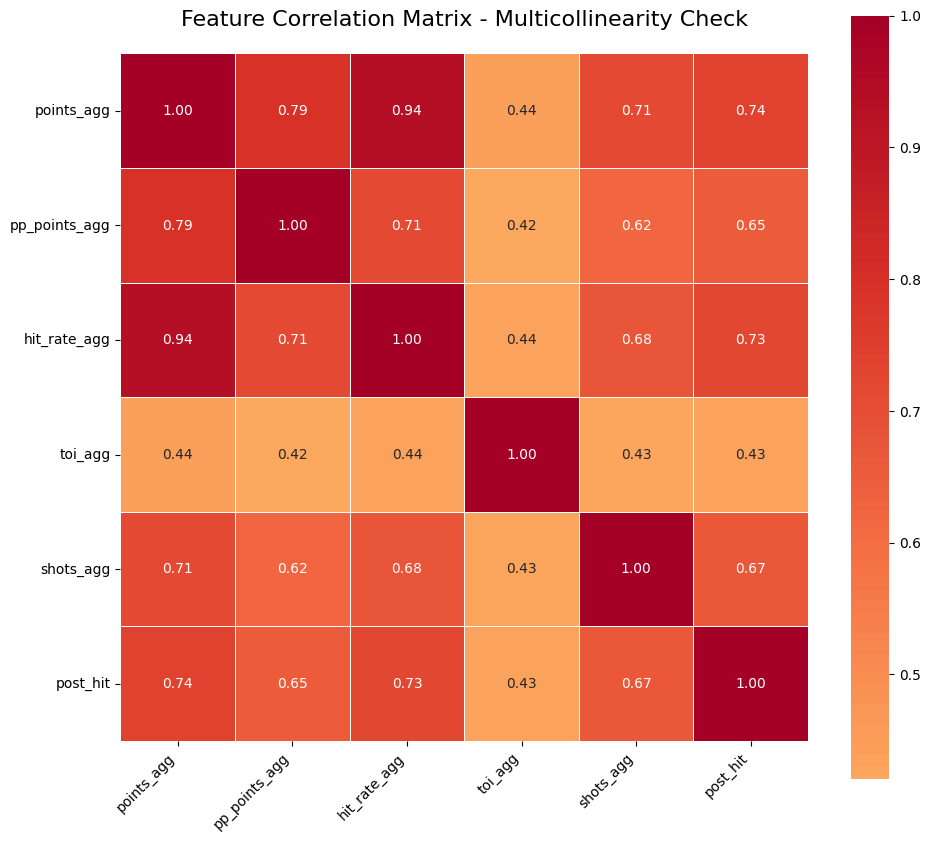

In [3]:
corr_matrix = gm_logs[['points_agg', 'pp_points_agg',
                         'hit_rate_agg','toi_agg', 'shots_agg','post_hit']].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, 
            annot=True,           # Show correlation values
            fmt='.2f',            # 2 decimal places
            cmap='RdYlGn_r',      # Red (high correlation) to Green (low)
            center=0,             # Center colormap at 0
            square=True,          # Square cells
            linewidths=0.5,       # Grid lines
            cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Matrix - Multicollinearity Check', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [4]:
gm_logs=gm_logs[gm_logs['season']==20232024]

##join ind szn and career on playerid and seasonid
indy_df=pd.merge(gm_logs, career_to_date_stats,how='left',left_on=['playerId','season'],right_on=['playerId','seasonId'])

##join team_for on indy
indy_team_for=pd.merge(indy_df, team_level_data,how='left',on=['gameId','teamAbbrev'])

indy_teams_both=pd.merge(indy_team_for,team_level_data_against,how='left',left_on=['gameId','teamAbbrev'],right_on=['gameId','opponentAbbrev'])

goalies_added=pd.merge(indy_teams_both,gm_logs_goalie,how='left',left_on=['gameId','teamAbbrev'],right_on=['gameId','opponentAbbrev'])

###
final_df=goalies_added.drop(columns=['seasonId','teamAbbrevs','opponentAbbrev_x','opponentAbbrev_y'])

model_df=final_df.drop(columns=['gameId','playerId','teamAbbrev','season','rookie_yr_points'
                                ,'rookie_yr_pp_points','rookie_yr_gp','rookie_yr_toi'
                                ,'szn_no']).dropna()


In [5]:
##fwd_only_model
fwd_model_df=model_df[model_df['positionCode']=='F'].drop(columns=['positionCode'] )

In [6]:
y=fwd_model_df['pts_scored_ind']
X=fwd_model_df.drop(columns=['pts_scored_ind','draftRound','isRookie','l30_toi_avg', 'l5_toi_avg','l5_shots_pg','l30_shots_pg',
                             'l30_hit_rate', 'l5_hit_rate','l30_pp_pts_pg', 'l5_pp_pts_pg','l30_pts_pg', 'l5_pts_pg'])

X_train, X_test, y_train, y_test = train_test_split(X,y,
    random_state=13, shuffle = True, test_size=.2,  stratify=y)

# XG Boost

Default Model Accuracy on training set: 0.851
Default Model Accuracy on test set: 0.667
Default Model F1 Score: 0.539320614239181


<Figure size 1000x800 with 0 Axes>

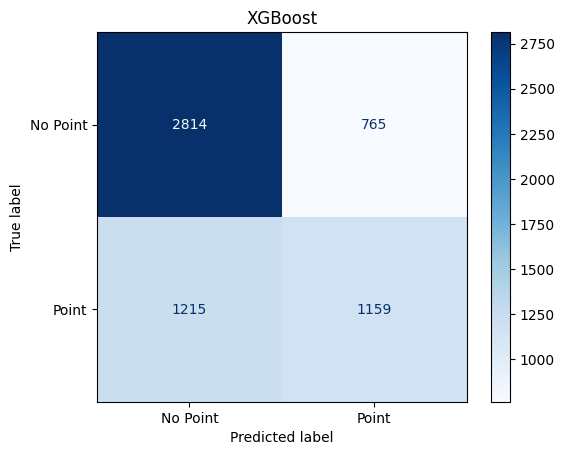

In [7]:
n_features_base=X.shape[1]
xgb_model=XGBClassifier(random_state=13)

xgb_model.fit(X_train, y_train)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

print("Default Model Accuracy on training set: {:.3f}".format(accuracy_score(y_train, y_pred_train)))
print("Default Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred_test)))
f1 = f1_score(y_test, y_pred_test)
print("Default Model F1 Score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred_test)
# print("Default Model Confusion Matrix for Test Set:")
# print(conf_matrix)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) ## base params plot
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost')
plt.yticks([0,1],['No Point','Point'])
plt.xticks([0,1],['No Point','Point'])
plt.show()

In [8]:
###hyperparam tuning
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2,4,6,8,10],
    'learning_rate': [0.05, 0.01, 0.1, 0.3]
    ,'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV with n_jobs=-1
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.6540640110033109


Default Model Accuracy on test set: 0.651
Best Model precision Score: 0.6303191489361702


<Figure size 1000x800 with 0 Axes>

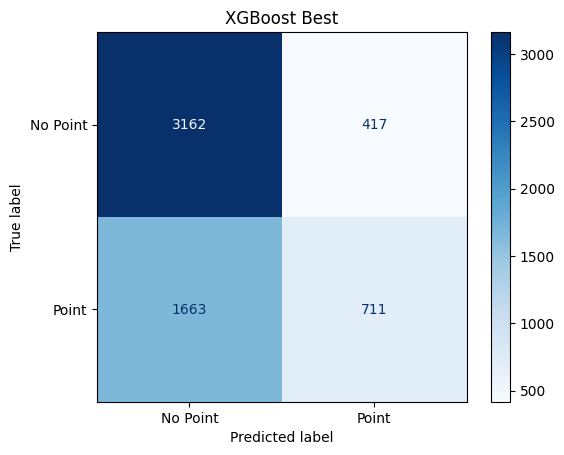

In [9]:
xgb_best=XGBClassifier(learning_rate= 0.01, max_depth= 8, n_estimators= 100, colsample_bytree=0.8, subsample= 0.8,random_state=13)
xgb_best.fit(X_train, y_train)

best= xgb_best.predict(X_test)

#print("Default Model Accuracy on training set: {:.3f}".format(accuracy_score(y_train, y_pred_train)))
print("Default Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test, best)))
precision = precision_score(y_test, best)
print("Best Model precision Score:", precision)

conf_matrix = confusion_matrix(y_test, best)
# print("Default Model Confusion Matrix for Test Set:")
# print(conf_matrix)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) ## base params plot
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Best')
plt.yticks([0,1],['No Point','Point'])
plt.xticks([0,1],['No Point','Point'])
plt.show()

#pd.Series(best)

### Random Forest

Default Model Accuracy on training set: 0.743
Default Model Accuracy on test set: 0.664
Default Model F1 Score: 0.506660088801184


<Figure size 1000x800 with 0 Axes>

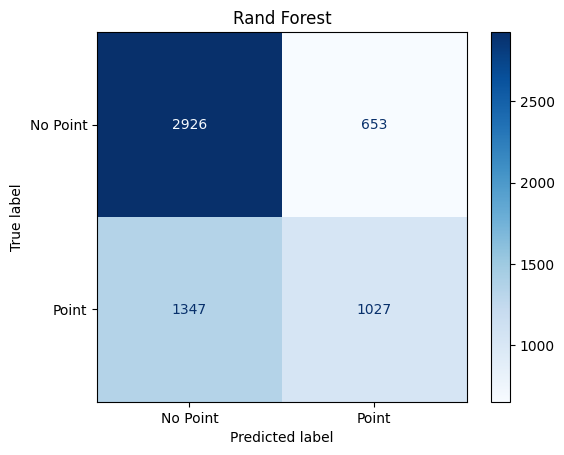

In [10]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_pred_train_rf = rf_clf.predict(X_train)
y_pred_test_rf = rf_clf.predict(X_test)

print("Default Model Accuracy on training set: {:.3f}".format(accuracy_score(y_train, y_pred_train_rf)))
print("Default Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred_test_rf)))
f1 = f1_score(y_test, y_pred_test_rf)
print("Default Model F1 Score:", f1)

conf_matrix_rf = confusion_matrix(y_test, y_pred_test_rf)
# print("Default Model Confusion Matrix for Test Set:")
# print(conf_matrix)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf) ## base params plot
disp.plot(cmap=plt.cm.Blues)
plt.title('Rand Forest')
plt.yticks([0,1],['No Point','Point'])
plt.xticks([0,1],['No Point','Point'])
plt.show()

In [11]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

y_pred_best_rf = best_model_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)

print("Best Parameters:", best_params_rf)
print(f"Best Model Accuracy: {accuracy_best_rf}")
print(f"Best Model Precision: {precision_best_rf}")

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Model Accuracy: 0.6764656475726525
Best Model Precision: 0.6222707423580786


# Gradient Boost

Default Model Accuracy on training set: 0.680
Default Model Accuracy on test set: 0.654
Default Model F1 Score: 0.4926181102362205


<Figure size 1000x800 with 0 Axes>

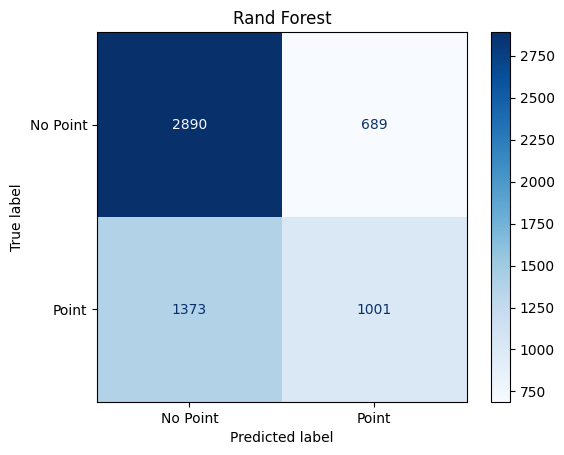

In [12]:
gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    #max_depth=4,
    #max_features=2,
    random_state=13)

gb_clf.fit(X_train, y_train)

y_pred_train_gb = gb_clf.predict(X_train)
y_pred_test_gb = gb_clf.predict(X_test)

print("Default Model Accuracy on training set: {:.3f}".format(accuracy_score(y_train, y_pred_train_gb)))
print("Default Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred_test_gb)))
f1 = f1_score(y_test, y_pred_test_gb)
print("Default Model F1 Score:", f1)

conf_matrix_gb = confusion_matrix(y_test, y_pred_test_gb)
# print("Default Model Confusion Matrix for Test Set:")
# print(conf_matrix)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb) ## base params plot
disp.plot(cmap=plt.cm.Blues)
plt.title('Rand Forest')
plt.yticks([0,1],['No Point','Point'])
plt.xticks([0,1],['No Point','Point'])
plt.show()

In [13]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

gb_model = GradientBoostingClassifier()

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_
best_model_gb = grid_search_gb.best_estimator_

y_pred_best_gb = best_model_gb.predict(X_test)
accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
precision_best_gb = precision_score(y_test, y_pred_best_gb)

print("Best Parameters:", best_params_gb)
print(f"Best Model Accuracy: {accuracy_best_gb}")
print(f"Best Model Precision: {precision_best_gb}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Model Accuracy: 0.6158239543087519
Best Model Precision: 0.6968325791855203


Default Model Accuracy on test set: 0.616
Best Model precision Score: 0.7037037037037037


<Figure size 1000x800 with 0 Axes>

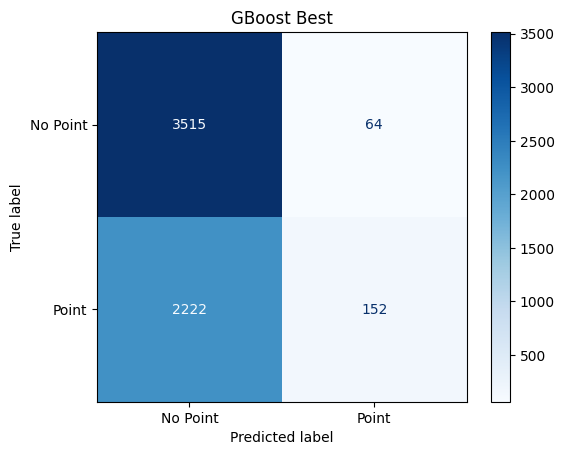

In [14]:
gb_best=XGBClassifier(learning_rate= 0.01, max_depth= 3, n_estimators= 50,random_state=13)
gb_best.fit(X_train, y_train)

best= gb_best.predict(X_test)

#print("Default Model Accuracy on training set: {:.3f}".format(accuracy_score(y_train, y_pred_train)))
print("Default Model Accuracy on test set: {:.3f}".format(accuracy_score(y_test, best)))
precision = precision_score(y_test, best)
print("Best Model precision Score:", precision)

conf_matrix = confusion_matrix(y_test, best)
# print("Default Model Confusion Matrix for Test Set:")
# print(conf_matrix)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) ## base params plot
disp.plot(cmap=plt.cm.Blues)
plt.title('GBoost Best')
plt.yticks([0,1],['No Point','Point'])
plt.xticks([0,1],['No Point','Point'])
plt.show()

## Partial Dependence Plots

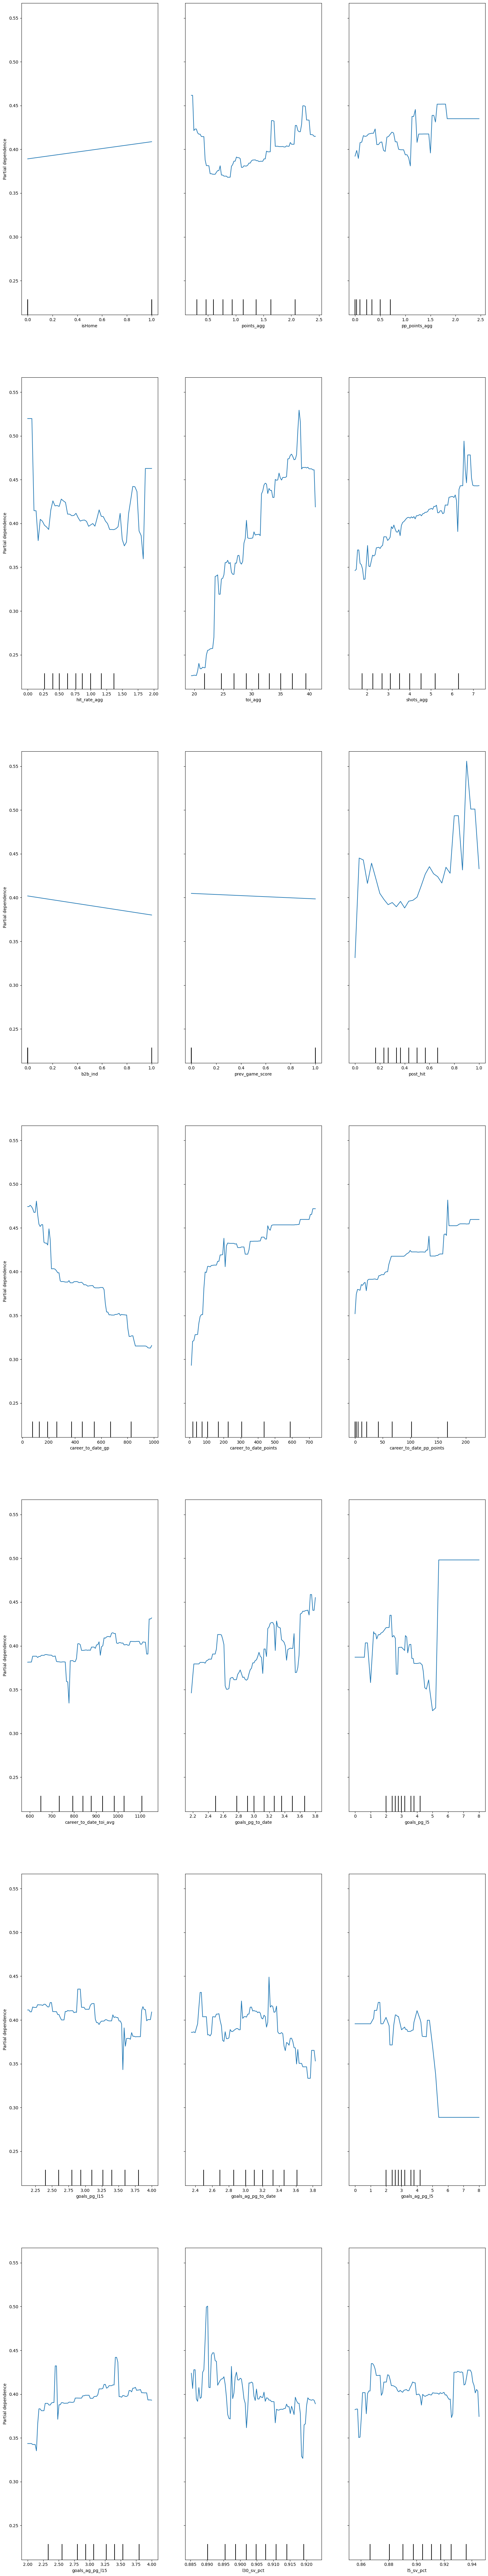

In [15]:
fig, ax = plt.subplots(figsize=(16, 4 * X.shape[1]))

PartialDependenceDisplay.from_estimator(
    xgb_model,
    X,
    features=list(range(X.shape[1])),  # All features
    ax=ax
)

plt.tight_layout()
plt.show()